# MPC satellite attitude controller with an external disturbence 

Simulation step 1/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 2/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 3/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 4/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 5/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 6/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 7/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 8/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 9/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 10/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 11/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 12/3094
Starting MPC optimization...
MPC optimization completed.
Simulation step 13/3094
Starting MPC 

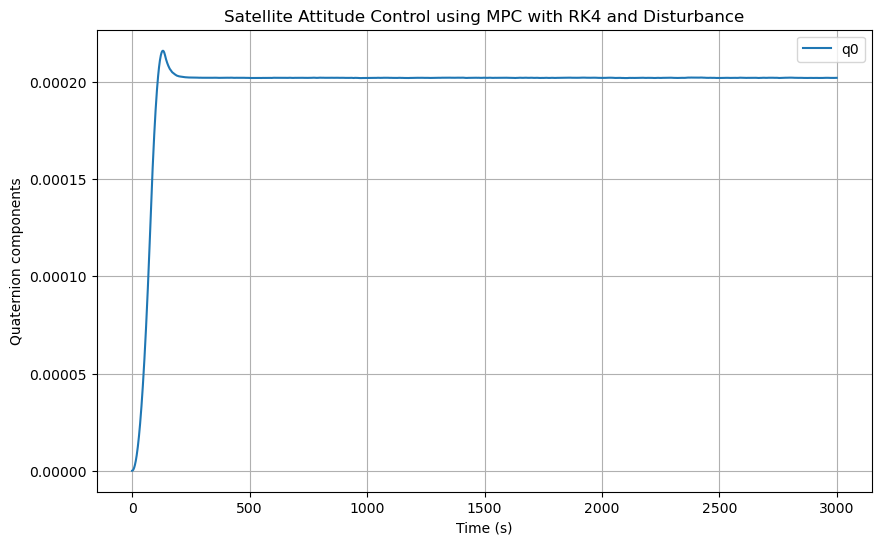

In [5]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Satellite parameters
I = np.diag([1191, 1844, 1798])  # Moment of inertia
dt = 0.9696  # Time step
N = 30  # Prediction horizon
M = 10  # Control horizon


# Initial and target states
q_init = np.array([1, 0, 0, 0])  # Initial quaternion
#q_target = np.array([0.9938, 0.086, 0.0513, 0.0608])  # Target quaternion
q_target = np.array([1, 0, 0, 0])  # Target quaternion (no rotation)
omega_init = np.zeros(3)  # Initial angular velocity
max_angular_velocity = 0.002269  # Maximum angular velocity

# Define external disturbance torque (example: constant disturbance)
disturbance_torque = np.array([0.0001, 0.0, 0.0])  # Example disturbance torque in Nm

# Quaternion multiplication
def quat_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

# Quaternion dynamics
def quaternion_derivative(q, omega):
    q_dot = 0.5 * quat_mult(q, np.array([0, *omega]))
    return q_dot

# Combined state derivative function with disturbance
def state_derivative(state, u, disturbance):
    q = state[:4]
    omega = state[4:]
    
    q_dot = quaternion_derivative(q, omega)
    # Include disturbance in omega_dot calculation
    omega_dot = np.linalg.inv(I) @ (u + disturbance - np.cross(omega, I @ omega))
    
    return np.concatenate([q_dot, omega_dot])

# RK4 step function
def rk4_step(state, u, dt, disturbance):
    k1 = state_derivative(state, u, disturbance)
    k2 = state_derivative(state + 0.5 * dt * k1, u, disturbance)
    k3 = state_derivative(state + 0.5 * dt * k2, u, disturbance)
    k4 = state_derivative(state + dt * k3, u, disturbance)
    return state + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

# Modified cost function for MPC with Control Horizon and max angular velocity
def cost_function(u, q_current, omega_current):
    total_cost = 0
    q = q_current.copy()
    omega = omega_current.copy()

    for i in range(N):
        if i < M:
            u_i = u[i*3:(i+1)*3]
        else:
            u_i = u[(M-1)*3:M*3]  # After control horizon, apply last optimized control

        state = np.concatenate([q, omega])
        state = rk4_step(state, u_i, dt, disturbance_torque)

        q = state[:4]
        q /= np.linalg.norm(q)  # Normalize quaternion
        omega = state[4:]

        q_error = 1 - np.dot(q, q_target)  # Quaternion error

        # Calculate the excess angular velocity
        angular_velocity_penalty = np.sum(np.maximum(np.abs(omega) - max_angular_velocity, 0)**2)

        # Add penalties for control effort and angular velocity
        total_cost += (6.0429 * q_error + 0.010537 * np.sum(u_i**2) + 1500 * angular_velocity_penalty)

    return total_cost

# Modified MPC control loop
def mpc_control(q_current, omega_current):
    print("Starting MPC optimization...")
    u_init = np.zeros(M * 3)  # Only optimize the first M control steps
    bounds = [(-0.25, 0.25)] * (M * 3)
    result = minimize(cost_function, u_init, args=(q_current, omega_current), method='SLSQP', bounds=bounds)
    print("MPC optimization completed.")
    return result.x[:3]

# Simulation loop
num_steps = int(3000/dt)  # Extend simulation time
q = q_init.copy()
omega = omega_init.copy()
# History storage
q_history = np.zeros((num_steps, 4))
omega_history = np.zeros((num_steps, 3))
control_torques = np.zeros((num_steps, 3))
time_history = np.zeros(num_steps)
total_simulation_time = 0  # Track total simulation time

for i in range(num_steps):
    print(f"Simulation step {i+1}/{num_steps}")
    q_history[i] = q
    omega_history[i] = omega
    time_history[i] = total_simulation_time

    # Apply MPC with the modified cost function
    u = mpc_control(q, omega)
    control_torques[i] = u

    # Update state using RK4, including disturbance
    state = np.concatenate([q, omega])
    state = rk4_step(state, u, dt, disturbance_torque)
    total_simulation_time += dt  # Accumulate the time step

    q = state[:4]
    q /= np.linalg.norm(q)  # Normalize quaternion
    omega = state[4:]

print(f"Simulation completed in {total_simulation_time} seconds. Plotting results...")
print(f"Step {i}: Quaternion = {q}, Control torques = {u}")

# Plotting results
time = time_history
plt.figure(figsize=(10, 6))
#plt.plot(time, q_history)
#only plot the q1 component
plt.plot(time, q_history[:,1])
plt.xlabel('Time (s)')
plt.ylabel('Quaternion components')
plt.legend(['q0', 'q1', 'q2', 'q3'])
plt.title('Satellite Attitude Control using MPC with RK4 and Disturbance')
plt.grid(True)
plt.show()


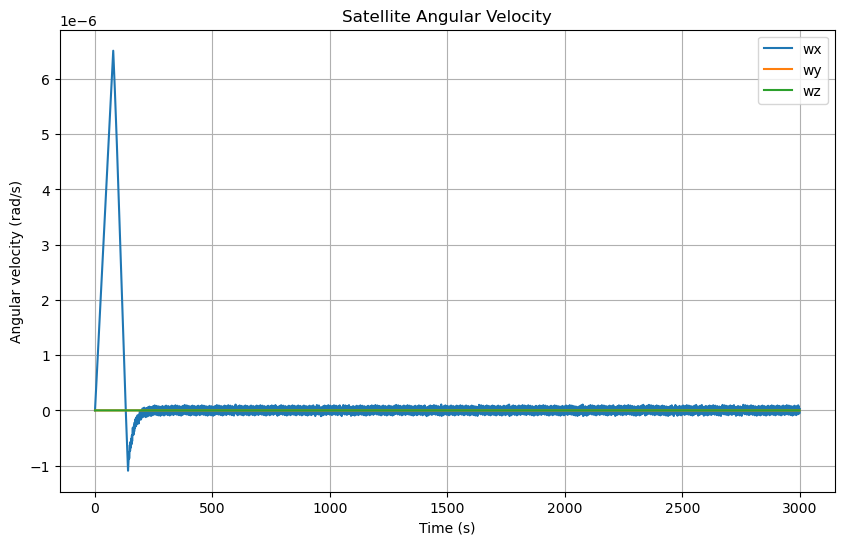

In [2]:
#plotting the angular velocity
plt.figure(figsize=(10, 6))
plt.plot(time, omega_history)
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (rad/s)')
plt.legend(['wx', 'wy', 'wz'])
plt.title('Satellite Angular Velocity')
plt.grid(True)
plt.show()

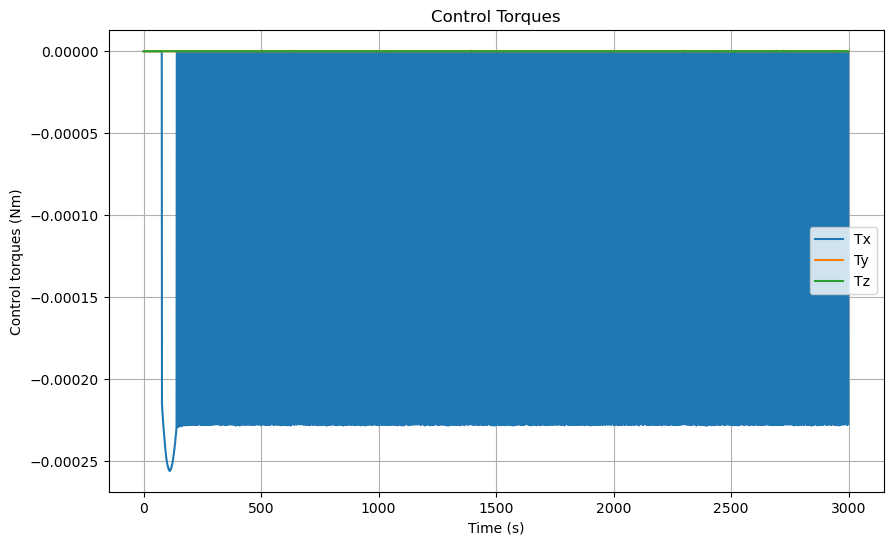

In [3]:
#plotting the control torques
plt.figure(figsize=(10, 6))
plt.plot(time, control_torques)
plt.xlabel('Time (s)')
plt.ylabel('Control torques (Nm)')
plt.legend(['Tx', 'Ty', 'Tz'])
plt.title('Control Torques')
plt.grid(True)
plt.show()

In [22]:
# save to csv
import pandas as pd
from datetime import datetime

#control_torques_history = np.array(control_torques_history)
# Exporting the data into a csv file
def save_simulation_to_csv(filename):
    data = {
        'time': time_history,
        'q0': q_history[:, 0],
        'q1': q_history[:, 1],
        'q2': q_history[:, 2],
        'q3': q_history[:, 3],
        'omega_x': omega_history[:, 0],
        'omega_y': omega_history[:, 1],
        'omega_z': omega_history[:, 2],
        'Total_torque_x': control_torques[:, 0],
        'Total_torque_y': control_torques[:, 1],
        'Total_torque_z': control_torques[:, 2],
    }
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = f"satellite_attitude_control_MPC_External_toruqe_10e2_Norotation_{date_time}.csv"
save_simulation_to_csv(file_name)